# ResNet FCN Pytorch
In this notebook we will load a resnet model from [pytorch](https://pytorch.org/hub/pytorch_vision_resnet/) and train it on our image dataset.

In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**MUST RESTART RUNTIME AFTER THIS PILLOW INSTALL**

In [2]:
# Path to project folder in Drive: /content/drive/MyDrive/02740/FinalProject
%cd /content/drive/MyDrive/02740/FinalProject
!pwd

# Necessaey to avoid torch error: https://github.com/pytorch/pytorch/issues/61125
%pip install pillow==8.2.0

/content/drive/MyDrive/02740/FinalProject
/content/drive/MyDrive/02740/FinalProject
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/02740/FinalProject/code')
# sys.path.append('/content/drive/MyDrive/02740/FinalProject/data/')

In [4]:
import numpy as np
import random
import time
import copy
from matplotlib import pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [6]:
SEED = 2740

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
from custom_torch_dataset import *
from eval_functions import *
from transforms import *

## Load Dataset

In [8]:
# Paths to directory with training images and the annotation csv file
train_data_dir = "/content/drive/MyDrive/02740/FinalProject/data/hubmap-organ-segmentation/train_images"
train_annot_path = '/content/drive/MyDrive/02740/FinalProject/data/hubmap-organ-segmentation/train_70-30.csv'
test_data_dir = "/content/drive/MyDrive/02740/FinalProject/data/hubmap-organ-segmentation/train_images"
test_annot_path = '/content/drive/MyDrive/02740/FinalProject/data/hubmap-organ-segmentation/test_70-30.csv'

### Data Transformations


Resnet requires that images are loaded in a range [0,1] then normalized mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

In [9]:
# train_preprocess = Compose([
#     ToTensor(),
#     Resize(256),
#     RandomHorizontalFlip(0.5),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# test_preprocess = Compose([
#     ToTensor(),
#     Resize(256),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [10]:
data_transforms = {
    'train': Compose([
    ToTensor(),
    Resize(256),
    RandomHorizontalFlip(0.5),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': Compose([
    ToTensor(),
    Resize(256),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

### Initialize Datasets

In [11]:
# Initialize custom dataset object
# train_dataset = SegDataset(root_dir=train_data_dir,annot_csv=train_annot_path,transform=train_preprocess)
# test_dataset = SegDataset(root_dir=test_data_dir,annot_csv=test_annot_path,transform=test_preprocess)
# print('Train dataset size:',len(train_dataset))
# print('Test dataset size:',len(test_dataset))

In [12]:
num_workers = 2
batch_size = 8

# Create training and validation datasets
image_datasets = {'train': SegDataset(root_dir=train_data_dir,annot_csv=train_annot_path,transform=data_transforms['train']),
                  'val': SegDataset(root_dir=test_data_dir,annot_csv=test_annot_path,transform=data_transforms['val']),
}

# Create training and validation dataloaders
dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, 
                    shuffle=True, num_workers=num_workers),
                    'val': torch.utils.data.DataLoader(image_datasets['val'],batch_size=8, 
                    shuffle=True, num_workers=num_workers),
}

In [13]:
# for inputs, labels, x in dataloaders_dict['train']:
# for x in dataloaders_dict['train']:
  # print(xs)
  # print(type(inputs),inputs.size())
  # print(type(labels),labels.size())
  # print(type(x))

  # break

Vizualize data

In [14]:
# for i in range(len(train_dataset)):
#     img, mask, sample = train_dataset[i]
#     print(img.shape,mask.shape)

#     fig, axs = plt.subplots(1,2)
#     fig.suptitle(f'{sample["id"]}.tiff: {sample["data_source"]} {sample["organ"]}')
#     axs[0].imshow(img.transpose(0,2))
#     axs[1].imshow(mask.squeeze())
#     plt.tight_layout()
#     plt.show()

#     if i == 1:
#         break

In [15]:
# for i in range(len(image_datasets['train'])):
#     img, mask, sample = image_datasets['train'][i]
#     print(img.shape,mask.shape)

#     fig, axs = plt.subplots(1,2)
#     fig.suptitle(f'{sample["id"]}.tiff: {sample["data_source"]} {sample["organ"]}')
#     axs[0].imshow(img.transpose(0,2))
#     axs[1].imshow(mask.squeeze())
#     plt.tight_layout()
#     plt.show()

#     if i == 1:
#         break

## Helper functions

In [16]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, is_inception=False):
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.

    for epoch in range(num_epochs):
        e_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0
            # running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        # print(f'Intput size: {inputs.size()}')
                        # outputs = model(inputs)['out'][:,1,:,:].unsqueeze(1) #.argmax(1).unsqueeze(1)
                        outputs = model(inputs)['out'] #.argmax(1).unsqueeze(1)
                        # print(f'Output size, label size: {outputs.size()} , {labels.size()}')
                        loss = criterion(outputs.float(), labels.float())

                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # for param in model.parameters():
                        #     param.retain_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            e_elapsed = time.time() - e_start
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            else:
                train_loss_history.append(epoch_loss)


        print(f'Epoch {epoch+1} took {int(e_elapsed // 60)}m {int(e_elapsed % 60)}s')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_loss_history, val_loss_history


In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "fcn_resnet50":
        """ FCN-Resnet50
        """
        model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        # model_ft.classifier[5] = nn.Sigmoid()

    elif model_name == "fcn_resnet101":
        """ FCN-Resnet101
        """
        model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
        # model_ft.classifier[5] = nn.Sigmoid()

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft


## Load Resnet Model

Pytorch implentations of FCN-RESNET

In [19]:
# fcn_model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
# fcn_model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)

Modify final layer to accomodate desired number of classes

In [20]:
# Modify last layer to predict 2 classes
# fcn_model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
# fcn_model.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
# print(fcn_model)

Load model with helper functions

In [21]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "fcn_resnet50"

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# batch_size = 8

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [22]:
# Initialize the model for this run
fcn_model = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(fcn_model)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

### Model optimizer

In [23]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
# Send the model to available device
fcn_model = fcn_model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = fcn_model.parameters()
# print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in fcn_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
# else:
#     for name,param in fcn_model.named_parameters():
#         if param.requires_grad == True:
#             # print("\t",name)

# Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_update, lr=0.003, momentum=0.9,)

# Adam MAXIMIZE (For Dice Coeff)
optimizer = optim.SGD(params_to_update, lr=0.003, momentum=0.9,maximize=True)


## Model Training and Validation

### Model criterion

In [25]:
# Setup the loss fxn
# criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()


Taking ~4 minutes per epoch with batchsize = 8

In [26]:
# Train and evaluate
inception = False

fcn_model, train_loss_hist, val_loss_hist = train_model(fcn_model, dataloaders_dict, criterion, optimizer, device, num_epochs=num_epochs,
                              is_inception=inception)

Epoch 1/20
----------
train Loss: 0.1709
val Loss: 0.1911
Epoch 1 took 5m 35s

Epoch 2/20
----------
train Loss: 0.2194
val Loss: 0.2392
Epoch 2 took 1m 40s

Epoch 3/20
----------
train Loss: 0.2681
val Loss: 0.2783
Epoch 3 took 1m 42s

Epoch 4/20
----------
train Loss: 0.3124
val Loss: 0.3265
Epoch 4 took 1m 43s

Epoch 5/20
----------
train Loss: 0.3676
val Loss: 0.3952
Epoch 5 took 1m 43s

Epoch 6/20
----------
train Loss: 0.4295
val Loss: 0.4784
Epoch 6 took 1m 44s

Epoch 7/20
----------
train Loss: 0.4993
val Loss: 0.5319
Epoch 7 took 1m 42s

Epoch 8/20
----------
train Loss: 0.5728
val Loss: 0.5739
Epoch 8 took 1m 42s

Epoch 9/20
----------
train Loss: 0.5717
val Loss: 0.5909
Epoch 9 took 1m 44s

Epoch 10/20
----------
train Loss: 0.6401
val Loss: 0.6117
Epoch 10 took 1m 44s

Epoch 11/20
----------
train Loss: 0.6542
val Loss: 0.6299
Epoch 11 took 1m 45s

Epoch 12/20
----------
train Loss: 0.6615
val Loss: 0.6453
Epoch 12 took 1m 46s

Epoch 13/20
----------
train Loss: 0.6845
val 

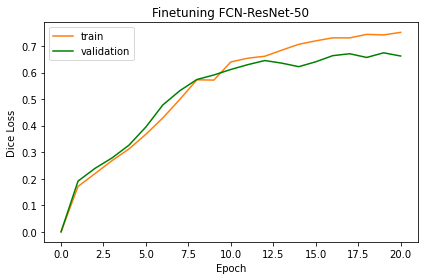

In [27]:
x = np.linspace(0,num_epochs,num_epochs+1)
plt.plot(x, [0]+train_loss_hist, color='tab:orange')
plt.plot(x, [0]+val_loss_hist, color='g')

plt.title('Finetuning FCN-ResNet-50')
plt.ylabel('Dice Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'])
plt.tight_layout()
plt.savefig('FCN-ResNet50_v1_eval_plot1.png')

## Make predictions

In [30]:
def encodeRLE(arr):
    print('min, median, max:',np.min(arr),np.median(arr),np.max(arr))
    # Flatten array column wise
    flat = arr.ravel('F') # column-wise
    # print('len, sum:',len(flat),np.sum(flat))
    switches = np.nonzero(np.append(flat,0) - np.append(0,flat))[0]
    if len(switches) == 0:
      return np.array([])
    # print('len switches:',len(switches))
    counts = np.append(switches,switches[-1]) - np.append(0,switches)

    # print(len(switches),len(switches[::2][:,None]),len(counts),len(counts[1::2][:,None]))
    counts = counts[:-1]
    rle = np.hstack((switches[::2][:,None],counts[1::2][:,None]))
    
    return rle.ravel()


# Each epoch has a training and validation phase
phase = 'val'
is_inception = False

fcn_model.eval()   # Set model to evaluate mode

running_loss = 0

# Iterate over data.
for inputs, labels, samples in dataloaders_dict['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    print(samples['id'])

    # zero the parameter gradients
    # optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(phase == 'train'):
        # Make predictions
        outputs = fcn_model(inputs)['out'] # [:,1,:,:].unsqueeze(1) #.argmax(1).unsqueeze(1)
        print(f'Output size, label size: {outputs.size()} , {labels.size()}')
        # print('single value',outputs[0,0,0,0].item())
        # loss = criterion(outputs.float(), labels.float())

        # Write predictions to file
        with open('submission.csv','w') as sub:
            sub.write('id,rle\n')
            # for inx, row in enumerate(samples.iterrows()):
            if len(outputs) != 1:
                for inx in range(len(outputs)):
                    # print('output:\n', outputs[0,:,110:130,110:130])
                    h_out, w_out = samples['img_height'][inx].item(),samples['img_width'][inx].item()
                    up = nn.Upsample(size=(h_out,w_out),mode='nearest')
                    # print('pre pred shape:',outputs[inx,:,:,:].shape)
                    pred = outputs[inx,:,:,:].argmax(axis=0)
                    # print('pred shape:',pred.shape)
                    mask = up(pred[None,None,:,:].float())[0,0,:,:].cpu().numpy()
                    # print('mask shape:',mask.shape)
                    rle = np.array2string(encodeRLE(mask))[1:-1]
                    # print('RLE:',rle[:20])
                    sub.write(f'{samples["id"][inx].item()},{rle}\n')
            else:
                # print('output:\n', outputs[0,:,110:130,110:130])
                h_out, w_out = samples['img_height'],samples['img_width']
                up = nn.Upsample(size=(h_out,w_out),mode='nearest')
                # print('pre pred shape:',outputs[0,:,:,:].shape)
                pred = outputs[0,:,:,:].argmax(axis=0)
                # print('pred shape:',pred.shape)
                mask = up(pred[None,None,:,:].float())[0,0,:,:].cpu().numpy()
                # print('mask shape:',mask.shape)
                rle = np.array2string(encodeRLE(mask))[1:-1]
                # print('RLE:',rle[:20])
                sub.write(f'{samples["id"].item()},{rle}\n')

        
        

tensor([ 5317,  6318,  6390,  8402,  7359,  3303, 30876,  9387])
Output size, label size: torch.Size([8, 1, 256, 256]) , torch.Size([8, 1, 256, 256])
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
tensor([  351, 30581, 31733,  8222,  9437,  5099,  9453,  5785])
Output size, label size: torch.Size([8, 1, 256, 256]) , torch.Size([8, 1, 256, 256])
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
tensor([ 7706,  4777,  8876,  8231, 31709,  9450,  9470,  8151])
Output size, label size: torch.Size([8, 1, 256, 256]) , torch.Size([8, 1, 256, 256])
min, median, max: 0.0 0.0 0.0
min, median, max: 0.0 0.0 0.0
min, media

In [29]:
np.array2string(np.arange(3,dtype=int))[1:-1]

'0 1 2'